# $\kappa_\lambda$ = 10 investigation

**Motivation:** We've been doing a lot of studies on the pairing accuracy, but although we have some awesome, creative ideas for helping our signal reconstruction, I found it *super interesting* that some of the ideas that I had to increase the signal accuracy were having a bigger than expected impact on the backround than I thought.


For example:
- Training pag w/ the b-tag or Db sort seemed to have a *worse* impact w/ the systematic
- Even min(dR) with the Db sort for the jets had a slightly worse systematic

We're starting to come to an understanding now that these are two fundamentally different regions of our analysis now.
Although this has been some intuition that we've been building up for quite some time, here I'm really just hoping to particularly investigate the signal efficiency for $\kappa_\lambda$ = 10 to answer the Qs:

1. Is there an event level cut we can apply for the quarks that retains higher (than MDR) efficiency for these events
2. What's special about events that failed the $\Delta \eta_{hh}$ cut
3. Where do events that failed the MDR cut go (i.e, are they still in our analysis regions, *or* are they outside of all of them, or do they end up failing the deta cut??)


In [105]:
import pandas as pd
import numpy as np
import itertools
from glob import glob 

import matplotlib.pyplot as plt

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

import os
os.sys.path += ['../RRevolution/code/',"../PAG-opt/","../PyATLASstyle/"]
from plots import *
from utils import fileDirSLAC as fileDir
from analysis import getXhh
# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


### Load in the data

For starters, just mc16a SM NR.


In [2]:
physicsSample = 'k10'
mc = 'mc16a'
prodTag = 'JUN20'

In [3]:
key = f'{physicsSample}_{mc}-{prodTag}'

filename = glob(fileDir[key]+'*.root')[0]
treename = "XhhMiniNtuple" 

f = uproot.open(filename)
tree = f[treename]

In [4]:
for k in tree.keys():
    if 'truth' in k.decode():
        print(k)

b'ntruth'
b'truth_E'
b'truth_pt'
b'truth_phi'
b'truth_eta'
b'truth_pdgId'
b'truth_status'
b'truth_barcode'
b'truth_is_higgs'
b'truth_is_bhad'
b'truth_Bdecay_x'
b'truth_Bdecay_y'
b'truth_Bdecay_z'
b'truth_nParents'
b'truth_parent_pdgId'
b'truth_parent_barcode'
b'truth_parent_status'
b'truth_nChildren'
b'truth_child_pdgId'
b'truth_child_barcode'
b'truth_child_status'
b'truth_mtt'
b'truth_mHH'
b'truth_pT_H1'
b'truthjet_antikt4_pt'
b'truthjet_antikt4_eta'
b'truthjet_antikt4_phi'
b'truthjet_antikt4_m'
b'truthjet_antikt10_pt'
b'truthjet_antikt10_eta'
b'truthjet_antikt10_phi'
b'truthjet_antikt10_m'


In [5]:
text = "$\mathbf{ATLAS}$ Simulation Internal\n"
text += f"{physicsSample} {mc} {prodTag} MNT"
text += "XhhCommon preselection"

In [6]:
tpdg = tree.array('truth_pdgId')

In [7]:
w = tree.array('mcEventWeight')

In [8]:
x = np.vstack(tpdg)

The first time I try to load ntruth, it takes a bit of time, so I was wondering if dask might be a better option.

## 1. Truth-level studies

After looking at distributions, it would also be interesting to scale the features, or (maybe) derive some weights to find a weighted distribution function?


In [9]:
# Get the pdgs and parent and child barcodes

pdg            = np.vstack(tree.array('truth_pdgId'))


In [10]:
mhh = tree.array('truth_mHH')
mhh *= 0.001 # Convert to GeV

In [11]:
mhh 

array([303.18597336, 276.07439946, 429.63441624, ..., 252.26564823,
       380.72893233, 418.56536987])

In [12]:
barcode        = np.vstack(tree.array('truth_barcode'))
higgs_barcodes = barcode[pdg == 25].reshape(-1,2)
higgs_barcodes.shape

(308146, 2)

I need to be careful to only access the parent information this way for truth $b$-quarks, b/c the higgs don't always have an attatched parent.

In [13]:
pbarc = tree.array('truth_parent_barcode')

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


In [14]:
b_parent_barcodes = np.vstack([[x[0] for pdg,x in zip(pdgs,ps) if np.abs(pdg) == 5] \
                                for pdgs,ps in zip(pdg,pbarc) ])

In [15]:
pt  = np.vstack(tree.array('truth_pt'))
eta = np.vstack(tree.array('truth_eta'))
phi = np.vstack(tree.array('truth_phi'))
E   = np.vstack(tree.array('truth_E'))

In [16]:
h_pt =  pt[pdg == 25].reshape(-1,2)
h_eta = eta[pdg == 25].reshape(-1,2)
h_phi = phi[pdg == 25].reshape(-1,2)
h_E   = E[pdg == 25].reshape(-1,2)

In [17]:
d_hpt = h_pt[:,0]-h_pt[:,1]
np.min(d_hpt)

0.0005950928

The truth Higgs's are sorted by $p_T$.

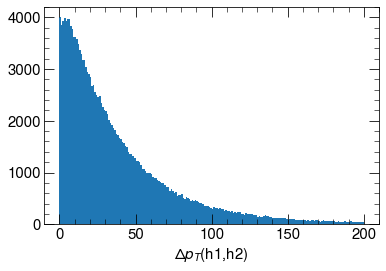

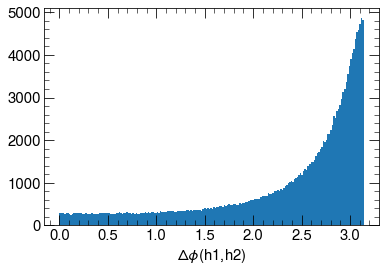

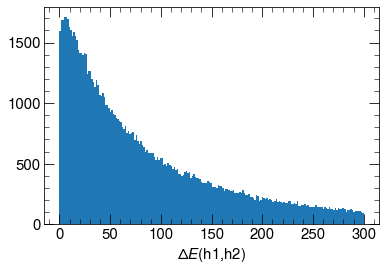

In [18]:
for v, xrange, xlabel in zip([h_pt,h_eta,h_phi,h_E],
                             [(0,200),(-5,5),None,(0,300)],
                             ['$p_T$','$\eta$','$\phi$','$E$']):
    plt.figure()
    dv = v[:,0]-v[:,1]
    if xlabel == '$\phi$':
        dv = np.arccos(np.cos(dv))
        
    plt.hist(dv,200,xrange,weights=w)
    plt.xlabel('$\Delta$'+xlabel+'(h1,h2)',fontsize=15)
plt.show()

Ok, this is *awesome*

1. We could apply a $\Delta phi_{hh}$ to help do S vs B
2. $\Delta \eta_{hh}$ has a *significant* number of events above 1.5

(But ofc, it'd be interesting to see how these evolve w/ the b-tagging + ... cuts


In [19]:
deta = np.abs(h_eta[:,0]-h_eta[:,1])

np.sum(w*(deta < 1.5))/np.sum(w)

0.78929704

**Q:** Do the *higher* $\Delta \eta_{hh}$ events correspond to lowe $m_{hh}$ (just thinking about the kinematics, it kind of seems like they should honestly).

In [20]:
plt.hist2d(mhh,deta,20,[(250,400),(0,3)],cmap='PuRd',
           weights=w)
plt.colorbar()

plt.plot([250,600],[1]*2,'k--')
plt.xlabel('m_hh')
plt.ylabel('deta_hh')

Text(0, 0.5, 'deta_hh')

In [21]:
dphi = np.arccos(np.cos(h_phi[:,0]-h_phi[:,1]))

In [22]:
plt.hist2d(deta,dphi,20,[(0,5),(3,np.pi)],cmap='PuRd',
           weights=w)

plt.ylabel('dphi_hh')
plt.xlabel('deta_hh')
plt.colorbar

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

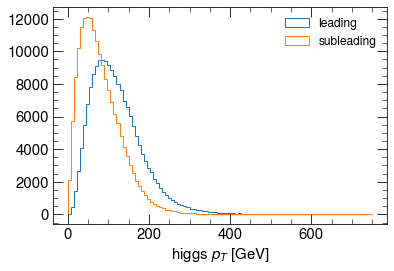

In [23]:
plt.hist(h_pt[:,0],100,(0,750),histtype='step',weights=w,label='leading')
plt.hist(h_pt[:,1],100,(0,750),histtype='step',weights=w,label='subleading')
plt.xlabel('higgs $p_T$ [GeV]',fontsize=15)
plt.legend(fontsize=12)
plt.show()

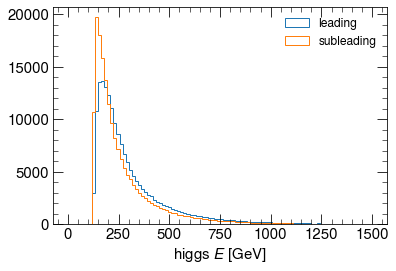

In [24]:
plt.hist(h_E[:,0],100,(0,1500),histtype='step',weights=w,label='leading')
plt.hist(h_E[:,1],100,(0,1500),histtype='step',weights=w,label='subleading')
plt.xlabel('higgs $E$ [GeV]',fontsize=15)
plt.legend(fontsize=12)
plt.show()

In [25]:
for v, xrange, xlabel in zip([h_pt,h_E],
                             [(0,1),None],
                             ['$p_T$','$E$']):
    plt.figure()
    dv = np.log(v[:,0])-np.log(v[:,1])
        
    plt.hist(dv,200,xrange,weights=w)
    plt.xlabel('$\Delta \log$'+xlabel+'(h1,h2)',fontsize=15)
plt.show()

Ok - interesting: for the SM, the Higgs are mostly back-to-back. It would be nice to see if this stays the same or not for the lower masses.

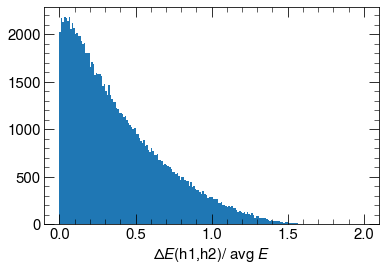

In [26]:
for v, xrange, xlabel in zip([h_pt,h_eta,h_phi,h_E],
                             [(0,1.5),(-5,5),(-5,5),(0,2)],
                             ['$p_T$','$\eta$','$\phi$','$E$']):
    plt.figure()
    dv = v[:,0]-v[:,1]
    vavg = 0.5*(v[:,0]+v[:,1])
    if xlabel == '$\phi$':
        dv = np.arccos(np.cos(dv))
    plt.hist(dv/vavg,200,xrange,weights=w)
    plt.xlabel('$\Delta$'+xlabel+'(h1,h2)'+'/ avg '+xlabel,fontsize=15)
plt.show()

In [27]:
key

'k10_mc16a-JUN20'

Ok, maybe I fucked something up - but these don't look as intuitive to me.

**Next:** Look at the Euclidean distances for the truth $b$-quark pairs.

In [28]:
b_pt =  pt[np.abs(pdg) == 5].reshape(-1,4)
b_eta = eta[np.abs(pdg) == 5].reshape(-1,4)
b_phi = phi[np.abs(pdg) == 5].reshape(-1,4)
b_E   = E[np.abs(pdg) == 5].reshape(-1,4)

Let's try to retrieve indices for the bs

In [29]:
cols = [f'pair{pi}_b{i}{j}' for pi in range(3) for i in [1,2] for j in [1,2] ]
cols += ['correctPair']

In [30]:
df = pd.DataFrame(0, range(pt.shape[0]),cols)

In [31]:
b_pt.shape

(308146, 4)

In [32]:
for pi, (i11, i12, i21, i22) in enumerate([(0,1,2,3), (0,2,1,3), (0,3,1,2)]):
    
    print(f'HC1 : {i11} {i12}, HC2: {i21} {i22}')
    
    j11 = TLorentzVectorArray.from_ptetaphi(b_pt[:,i11], b_eta[:,i11], b_phi[:,i11], b_E[:,i11])
    j12 = TLorentzVectorArray.from_ptetaphi(b_pt[:,i12], b_eta[:,i12], b_phi[:,i12], b_E[:,i12])
    j21 = TLorentzVectorArray.from_ptetaphi(b_pt[:,i21], b_eta[:,i21], b_phi[:,i21], b_E[:,i21])
    j22 = TLorentzVectorArray.from_ptetaphi(b_pt[:,i22], b_eta[:,i22], b_phi[:,i22], b_E[:,i22])

    # Want to sort by HC pT!!!
    mask = (j11+j12).pt > (j21+j22).pt
    
    # Fill the leading HC entries
    df[f'pair{pi}_b11_pt']  = np.where(mask, j11.pt,  j21.pt)
    df[f'pair{pi}_b11_eta'] = np.where(mask, j11.eta, j21.eta)
    df[f'pair{pi}_b11_phi'] = np.where(mask, j11.phi, j21.phi)
    df[f'pair{pi}_b11_E']   = np.where(mask, j11.E,   j21.E)
    
    df[f'pair{pi}_b12_pt']  = np.where(mask, j12.pt,  j22.pt)
    df[f'pair{pi}_b12_eta'] = np.where(mask, j12.eta, j22.eta)
    df[f'pair{pi}_b12_phi'] = np.where(mask, j12.phi, j22.phi)
    df[f'pair{pi}_b12_E']   = np.where(mask, j12.E,   j22.E)
    
    # Fill the subleading HC entries
    df[f'pair{pi}_b21_pt']  = np.where(~mask, j11.pt,  j21.pt)
    df[f'pair{pi}_b21_eta'] = np.where(~mask, j11.eta, j21.eta)
    df[f'pair{pi}_b21_phi'] = np.where(~mask, j11.phi, j21.phi)
    df[f'pair{pi}_b21_E']   = np.where(~mask, j11.E,   j21.E)

    df[f'pair{pi}_b22_pt']  = np.where(~mask, j12.pt,  j22.pt)
    df[f'pair{pi}_b22_eta'] = np.where(~mask, j12.eta, j22.eta)
    df[f'pair{pi}_b22_phi'] = np.where(~mask, j12.phi, j22.phi)
    df[f'pair{pi}_b22_E']   = np.where(~mask, j12.E,   j22.E)
    
    
    hca = j11+j12
    hcb = j21+j22
    
    df[f'pair{pi}_h1_pt']  = np.where( mask, hca.pt,  hcb.pt)
    df[f'pair{pi}_h1_eta'] = np.where( mask, hca.eta, hcb.eta)
    df[f'pair{pi}_h1_phi'] = np.where( mask, hca.phi, hcb.phi)
    df[f'pair{pi}_h1_m']   = np.where( mask, hca.mass,hcb.mass)
    
    df[f'pair{pi}_h2_pt']  = np.where(~mask, hca.pt,  hcb.pt)
    df[f'pair{pi}_h2_eta'] = np.where(~mask, hca.eta, hcb.eta)
    df[f'pair{pi}_h2_phi'] = np.where(~mask, hca.phi, hcb.phi)
    df[f'pair{pi}_h2_m']   = np.where(~mask, hca.mass,hcb.mass)
    
    # Save whether this is the correct pair or not
    m2 = (b_parent_barcodes == higgs_barcodes[:,0].reshape(-1,1))
    correctPair = (m2[:,i11] & m2[:,i12]) | (m2[:,i21] & m2[:,i22])
    df.loc[correctPair,'correctPair'] = pi
    

HC1 : 0 1, HC2: 2 3
HC1 : 0 2, HC2: 1 3
HC1 : 0 3, HC2: 1 2


In [33]:
df['pt_hh'] = (j11+j12+j21+j22).pt

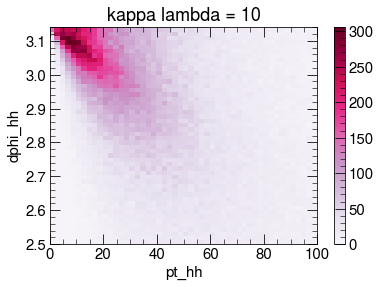

In [34]:
plt.hist2d(df.pt_hh,dphi,50,[(0,100),(2.5,np.pi)],
           cmap='PuRd',weights=w)

plt.xlabel('pt_hh')
plt.ylabel('dphi_hh')
plt.colorbar()
plt.title('kappa lambda = 10')

plt.show()

Yes!!!! Ok, this is *hella* convincing haha.

In [35]:
plt.hist2d(df.pt_hh,deta,50,[(0,100),(0,3)],
           cmap='PuRd',weights=w)

plt.xlabel('pt_hh')
plt.ylabel('deta_hh')
plt.colorbar()
plt.show()

*Still* no convincing trend haha.

In [36]:
m2[:,0] & m2[:,2]

array([False, False,  True, ..., False,  True, False])

In [37]:
np.unique(df.correctPair,return_counts=True)

(array([0, 1, 2]), array([ 37435,  98578, 172133]))

In [38]:
den = np.sum(w)
for pi in [0,1,2]:
    x = np.sum(w[df.correctPair==pi]) / den
    print(f'Pair {pi}: {100*x:.1f}')

Pair 0: 12.2
Pair 1: 32.0
Pair 2: 55.8


Ok - I need these numbers in terms of a weighted sum!!

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


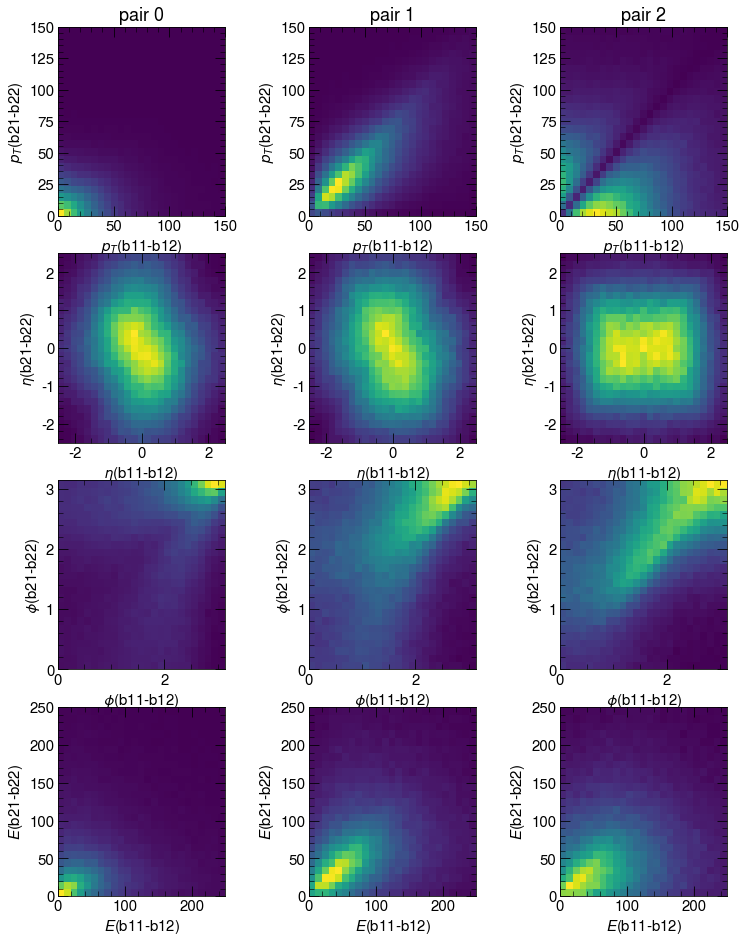

In [39]:
fig, axes = plt.subplots(4,3,figsize=(12,16))

for pi in range(3):
    
    # pt
    axes[0,pi].hist2d(df[f'pair{pi}_b11_pt'] - df[f'pair{pi}_b12_pt'],
                      df[f'pair{pi}_b21_pt'] - df[f'pair{pi}_b22_pt'],
                      25,[[0,150],[0,150]],weights=w)

    axes[0,pi].set_xlabel('$p_T$(b11-b12)')
    axes[0,pi].set_ylabel('$p_T$(b21-b22)')
    axes[0,pi].set_title(f'pair {pi}')
    axes[0,]
    
    # eta
    axes[1,pi].hist2d(df[f'pair{pi}_b11_eta'] - df[f'pair{pi}_b12_eta'],
                      df[f'pair{pi}_b21_eta'] - df[f'pair{pi}_b22_eta'],
                      25,[[-2.5,2.5],[-2.5,2.5]],weights=w)

    axes[1,pi].set_xlabel('$\eta$(b11-b12)')
    axes[1,pi].set_ylabel('$\eta$(b21-b22)')
    
    # phi
    axes[2,pi].hist2d(np.arccos(np.cos(df[f'pair{pi}_b11_phi'] - df[f'pair{pi}_b12_phi'])),
                      np.arccos(np.cos(df[f'pair{pi}_b21_phi'] - df[f'pair{pi}_b22_phi'])),
                      25,[[0,np.pi],[0,np.pi]],weights=w)

    axes[2,pi].set_xlabel('$\phi$(b11-b12)')
    axes[2,pi].set_ylabel('$\phi$(b21-b22)')
    
    # E
    axes[3,pi].hist2d(df[f'pair{pi}_b11_E'] - df[f'pair{pi}_b12_E'],
                      df[f'pair{pi}_b21_E'] - df[f'pair{pi}_b22_E'],
                      25,[[0,250],[0,250]],weights=w)

    axes[3,pi].set_xlabel('$E$(b11-b12)')
    axes[3,pi].set_ylabel('$E$(b21-b22)') 
    
fig.subplots_adjust(wspace=.5)
#plt.savefig('figures/truth_b_vars_allPairs.pdf',bbox_inches='tight')
fig.show()

Ok, this looks cool already. One of the things that I like right off the bat is how we can see how the kinematics vary with these types of pairings. It seems like angular information might be the most helpful, and interestingly, it's more likely to pair the highest $p_T$ quark with the lowest $p_T$ quark.

**Next:** Maybe some scatter plots to separate out info for correct vs incorrect pairs?

In [40]:
N=50000
s=w[:N]
alpha=1

fig, axes = plt.subplots(2,2,figsize=(7,7))

for pi in range(3):
    
    
    colors=['hotpink' if cp==pi else 'grey' for cp in df.correctPair][:N]
    
    axes[0,0].scatter((df[f'pair{pi}_b11_pt'] - df[f'pair{pi}_b12_pt'])[:N],
                      (df[f'pair{pi}_b21_pt'] - df[f'pair{pi}_b22_pt'])[:N],
                      s=s, alpha=alpha, color=colors)

    axes[0,0].set_xlabel('$\Delta p_T$(b11,b12)')
    axes[0,0].set_ylabel('$\Delta p_T$(b21,b22)')
    axes[0,0].set_xlim(0,150)
    axes[0,0].set_ylim(0,150)
    
    # eta
    axes[0,1].scatter((df[f'pair{pi}_b11_eta'] - df[f'pair{pi}_b12_eta'])[:N],
                      (df[f'pair{pi}_b21_eta'] - df[f'pair{pi}_b22_eta'])[:N],
                      s=s, alpha=alpha, color=colors)
    
    axes[0,1].set_xlabel('$\Delta\eta$(b11,b12)')
    axes[0,1].set_ylabel('$\Delta\eta$(b21,b22)')
    axes[0,1].set_xlim(-2.5,2.5)
    axes[0,1].set_ylim(-2.5,2.5)
    
    # phi
    axes[1,0].scatter(np.arccos(np.cos(df[f'pair{pi}_b11_phi'] - df[f'pair{pi}_b12_phi']))[:N],
                      np.arccos(np.cos(df[f'pair{pi}_b21_phi'] - df[f'pair{pi}_b22_phi']))[:N],
                      s=s, alpha=alpha, color=colors)

    axes[1,0].set_xlabel('$\Delta\phi$(b11,b12)')
    axes[1,0].set_ylabel('$\Delta\phi$(b21,b22)')
    axes[1,0].set_xlim(0,np.pi)
    axes[1,0].set_ylim(0,np.pi)
    
    # E
    axes[1,1].scatter((df[f'pair{pi}_b11_E'] - df[f'pair{pi}_b12_E'])[:N],
                      (df[f'pair{pi}_b21_E'] - df[f'pair{pi}_b22_E'])[:N],
                      s=s, alpha=alpha, color=colors)

    axes[1,1].set_xlabel('$\Delta E$(b11,b12)')
    axes[1,1].set_ylabel('$\Delta E$(b21,b22)') 
    axes[1,1].set_xlim(0,500)
    axes[1,1].set_ylim(0,500)
    
fig.subplots_adjust(wspace=.5)
#plt.savefig('figures/truth_b_vars_correctIncorrectPairs.png',bbox_inches='tight')

fig.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


This is just saying that $\Delta \phi$ and $\Delta \eta$ are good variables (like duh - but still nice to see lol).

Ok, cool! As expected, taking the log makes these look a lot more meaninful.

**Let's overlay histograms for correct and incorrect pairs**


In [41]:
correct = np.zeros((len(df),3)).astype(bool)

for pi in range(3):
    correct[df.correctPair==pi, pi]=True

In [42]:
dlogpt1 = np.log(df[[f'pair{pi}_b11_pt' for pi in range(3)]]).values - np.log(df[[f'pair{pi}_b12_pt' for pi in range(3)]]).values
dlogpt2 = np.log(df[[f'pair{pi}_b21_pt' for pi in range(3)]]).values - np.log(df[[f'pair{pi}_b22_pt' for pi in range(3)]]).values

deta1 = df[[f'pair{pi}_b11_eta' for pi in range(3)]].values - df[[f'pair{pi}_b12_eta' for pi in range(3)]].values
deta2 = df[[f'pair{pi}_b21_eta' for pi in range(3)]].values - df[[f'pair{pi}_b22_eta' for pi in range(3)]].values

dphi1 = np.arccos(np.cos(df[[f'pair{pi}_b11_phi' for pi in range(3)]].values - df[[f'pair{pi}_b12_phi' for pi in range(3)]])).values
dphi2 = np.arccos(np.cos(df[[f'pair{pi}_b21_phi' for pi in range(3)]].values - df[[f'pair{pi}_b22_phi' for pi in range(3)]])).values

dlogE1 = np.log(df[[f'pair{pi}_b11_E' for pi in range(3)]]).values - np.log(df[[f'pair{pi}_b12_E' for pi in range(3)]]).values
dlogE2 = np.log(df[[f'pair{pi}_b21_E' for pi in range(3)]]).values - np.log(df[[f'pair{pi}_b22_E' for pi in range(3)]]).values

In [43]:
dlogpt1.shape

(308146, 3)

In [44]:
w_3d = np.vstack([w for i in range(3)]).T
w_3d.shape

(308146, 3)

In [45]:
nBins = 50
myRange = (0,5)
fig, axes = plt.subplots(2,2,figsize=(7,7))

axes[0,0].hist(np.sqrt(dlogpt1**2+dlogpt2**2)[correct],nBins,myRange,color='hotpink',
               density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[0,0].hist(np.sqrt(dlogpt1**2+dlogpt2**2)[~correct],nBins,myRange,color='grey',
               density=True,histtype='step',label='Incorrect',weights=w_3d[~correct])

axes[0,0].set_xlabel('$\sqrt{ \log \Delta p_T(b11,b12)^2 + \log \Delta p_T(b11,b12)^2}$')
axes[0,0].set_ylabel('Normalized entries')
axes[0,0].legend()

# eta
m1,_,_ = axes[0,1].hist(np.sqrt(deta1**2+deta2**2)[correct],nBins,myRange,color='hotpink',
              density=True,histtype='step',label='Correct',weights=w_3d[correct])
m2,_,_ = axes[0,1].hist(np.sqrt(deta1**2+deta2**2)[~correct],nBins,myRange,color='grey',
              density=True,histtype='step',label='Incorrect',weights=w_3d[~correct])

axes[0,1].set_xlabel('$\sqrt{\Delta \eta (b11,b12)^2 + \Delta \eta (b11,b12)^2}$')
axes[0,1].set_ylabel('Normalized entries')
axes[0,1].legend()

# phi
axes[1,0].hist(np.sqrt(dphi1**2+dphi2**2)[correct],nBins,myRange,color='hotpink',
              density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[1,0].hist(np.sqrt(dphi1**2+dphi2**2)[~correct],nBins,myRange,color='grey',
              density=True,histtype='step',label='Incorrect',weights=w_3d[~correct])

axes[1,0].set_xlabel('$\sqrt{\Delta \phi(b11,b12)^2 + \Delta \phi (b11,b12)^2}$')
axes[1,0].set_ylabel('Normalized entries')
axes[1,0].legend(loc='upper left')


# E
axes[1,1].hist(np.sqrt(dlogE1**2+dlogE2**2)[correct],nBins,myRange,color='hotpink',
               density=True,histtype='step',label='Correct',weights=w_3d[correct])
axes[1,1].hist(np.sqrt(dlogE1**2+dlogE2**2)[~correct],nBins,myRange,color='grey',
               density=True,histtype='step',label='Incorrect',weights=w_3d[~correct])

axes[1,1].set_xlabel('$\sqrt{\log \Delta E(b11,b12)^2 + \log \Delta E(b11,b12)^2}$')
axes[1,1].set_ylabel('Normalized entries')
axes[1,1].legend()
    
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.5)

#plt.savefig('figures/truth_b_vars_correctIncorrectMarginals.png',bbox_inches='tight')
fig.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Ok, I think I have something fucked up rn, b/c there's a peak at around $\Delta \phi = \pi$...

Not necessarily, because this is two variables getting summed in quadrature, not one... but I'm not quite sure atm.


**Question:** What would be a good event level variable that would let us 

1. Capture the signal
2. Smoothly vary between these 2 regions?

In [46]:
for pi in range(3):
    for hi, deta,dphi in zip([1,2],[deta1,deta2],[dphi1,dphi2]):
    
        df[f'pair{pi}_deta_h{hi}'] = deta[:,pi]
        df[f'pair{pi}_dphi_h{hi}'] = dphi[:,pi]

        df[f'pair{pi}_dR_h{hi}'] = np.sqrt(df[f'pair{pi}_deta_h{hi}']**2 + df[f'pair{pi}_dphi_h{hi}']**2)

In [47]:
for pi in range(3):
    plt.hist(df[f'pair{pi}_dR_h1'],100,(0,5),histtype='step',lw=4,color=f'C{pi}',label='h1')
    plt.hist(df[f'pair{pi}_dR_h2'],100,(0,5),histtype='step',lw=4,color=f'C{pi}',label='h2',ls='--')

**Step 1:** Take *out* the pairs already where the correct pair reconstructed is the min_dR, b/c we already know how to deal w/ these.

In [48]:
df['chosen_min_dR'] = np.argmin(df[[f'pair{pi}_dR_h1' for pi in range(3)]].values,axis=1)

In [49]:
df[['chosen_min_dR','correctPair']]

chosen_min_dR  correctPair
0                   0            2
1                   2            0
2                   1            1
3                   2            1
4                   2            1
...               ...          ...
308141              1            2
308142              0            1
308143              0            1
308144              2            1
308145              2            2

[308146 rows x 2 columns]

How often in min_dR correct for $\kappa_\lambda = 10$? (W/ XhhCommon pre-sel??)

In [50]:
np.sum(w[df.chosen_min_dR==df.correctPair])/np.sum(w)

0.28145275

**Only 30% of the time!!**

(But ok, honestly, this # seems chill.)

**Step 2:** What's the difference b/w the reconstructed masses for the *true* higgs mass vs the min_dR HC mass?

Maybe first I should sanity check that everything is gucci here??

In [51]:
m_h1s = [f'pair{pi}_h1_m' for pi in range(3)]
m_h2s = [f'pair{pi}_h2_m' for pi in range(3)]

In [52]:
df[m_h1s].values[np.arange(len(df)),df.chosen_min_dR]

array([127.68764 ,  82.77487 , 125.000015, ...,  39.671795,  30.54978 ,
       125.00001 ], dtype=float32)

In [54]:
mask = df.chosen_min_dR!=df.correctPair

m1_chosen = df[m_h1s].values[np.arange(len(df)),df.chosen_min_dR][mask]
m2_chosen = df[m_h2s].values[np.arange(len(df)),df.chosen_min_dR][mask]

(0.0, 2751.5842163085936)

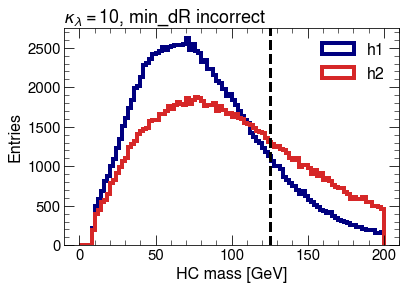

In [55]:
plt.hist(m1_chosen,100,(0,200),color='navy',histtype='step',lw=4,label='h1',
         weights=w[df.chosen_min_dR!=df.correctPair])
plt.hist(m2_chosen,100,(0,200),color='C3',histtype='step',lw=4,label='h2',
         weights=w[df.chosen_min_dR!=df.correctPair])

plt.xlabel('HC mass [GeV]',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('$\kappa_\lambda = 10$, min_dR incorrect',loc='left')
plt.legend(fontsize=16)


ylim = plt.ylim()
plt.plot([125]*2,ylim,'k--')

plt.ylim(ylim)

In [56]:
df.columns

Index(['pair0_b11', 'pair0_b12', 'pair0_b21', 'pair0_b22', 'pair1_b11',
       'pair1_b12', 'pair1_b21', 'pair1_b22', 'pair2_b11', 'pair2_b12',
       ...
       'pair1_deta_h2', 'pair1_dphi_h2', 'pair1_dR_h2', 'pair2_deta_h1',
       'pair2_dphi_h1', 'pair2_dR_h1', 'pair2_deta_h2', 'pair2_dphi_h2',
       'pair2_dR_h2', 'chosen_min_dR'],
      dtype='object', length=105)

In [57]:
dR1s = [f'pair{pi}_dR_h1' for pi in range(3)]
dR2s = [f'pair{pi}_dR_h2' for pi in range(3)]

dR1_chosen = df[dR1s].values[np.arange(len(df)),df.chosen_min_dR][mask]
dR2_chosen = df[dR2s].values[np.arange(len(df)),df.chosen_min_dR][mask]

In [58]:
plt.hist(dR1_chosen,100,(0,5),color='navy',histtype='step',lw=4,label='h1',
         weights=w[df.chosen_min_dR!=df.correctPair])
plt.hist(dR2_chosen,100,(0,5),color='C3',histtype='step',lw=4,label='h2',
         weights=w[df.chosen_min_dR!=df.correctPair])

plt.xlabel('$\Delta R_{jj}$',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('$\kappa_\lambda = 10$, min_dR incorrect',loc='left')
plt.legend(fontsize=16)

plt.show()

**Thoughts**
- Clearly (as was demonstrated by all of our min_dR background massplane plots), the leading HC mass is the HC driving us outside of the SR
- In some way, you can also see the "asymmetry" that Todd was talking about, but I'm hoping to find *another* variable to encode this more efficiently.


**Furthermore - it's going to be *hard* to land incorrectly paired events in the SR**

**Goal:** Find a new pair of variables to denote the SR.

In [59]:
m1_correct = df[m_h1s].values[np.arange(len(df)),df.correctPair][mask]
m2_correct = df[m_h2s].values[np.arange(len(df)),df.correctPair][mask]

In [60]:

N = np.sum(mask)
other = np.ones((N,3)).astype(bool)

other[range(N),df.loc[mask,'chosen_min_dR']] = False
other[range(N),df.loc[mask,'correctPair']] = False

m1_other = df.loc[mask,m_h1s].values[other]
m2_other = df.loc[mask,m_h2s].values[other]

Text(0.5, 0.98, '$\\kappa_\\lambda = 10$, min_dR incorrect')

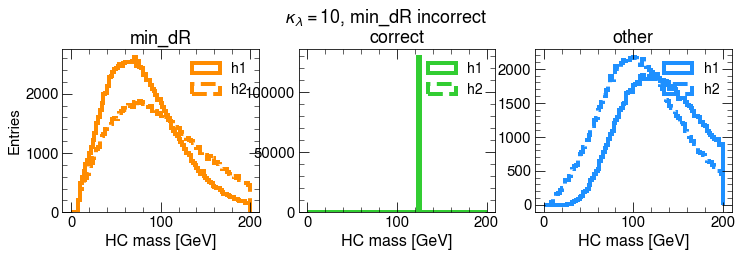

In [61]:
fig, axes = plt.subplots(1,3,figsize=(12,3))

for ax, m1,m2,c,t in zip(axes,[m1_chosen,m1_correct,m1_other],[m2_chosen,m2_correct,m2_other],
                         ['darkorange','limegreen','dodgerblue'],['min_dR','correct','other']):

    ax.hist(m1,100,(0,200),color=c,histtype='step',lw=4,label='h1',
             weights=w[mask])
    ax.hist(m2,100,(0,200),color=c,histtype='step',lw=4,label='h2',ls='--',
             weights=w[mask])

    ax.set_xlabel('HC mass [GeV]',fontsize=16)
    ax.set_title(t)
    ax.legend()

axes[0].set_ylabel('Entries')
fig.suptitle('$\kappa_\lambda = 10$, min_dR incorrect',va='bottom')

Ok - right, this was a little bit silly to do.

I think the most interesting point of this plot is that the "other" categorty has the higher $p_T$ HC with a lower mass.

**Next:** Let's make the same plot, but with $\Delta R$s

In [62]:
dR1_correct = df[dR1s].values[np.arange(len(df)),df.correctPair][mask]
dR2_correct = df[dR2s].values[np.arange(len(df)),df.correctPair][mask]

dR1_other = df.loc[mask,dR1s].values[other]
dR2_other = df.loc[mask,dR2s].values[other]

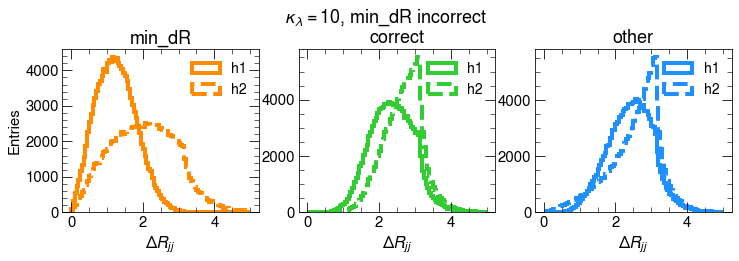

In [63]:
fig, axes = plt.subplots(1,3,figsize=(12,3))

for ax, dR1,dR2,c,t in zip(axes,[dR1_chosen,dR1_correct,dR1_other],
                           [dR2_chosen,dR2_correct,dR2_other],
                           ['darkorange','limegreen','dodgerblue'],
                           ['min_dR','correct','other']):

    ax.hist(dR1,100,(0,5),color=c,histtype='step',lw=4,label='h1',
             weights=w[mask])
    ax.hist(dR2,100,(0,5),color=c,histtype='step',lw=4,label='h2',ls='--',
             weights=w[mask])

    ax.set_xlabel('$\Delta R_{jj}$',fontsize=16)
    ax.set_title(t)
    ax.legend()

axes[0].set_ylabel('Entries')
fig.suptitle('$\kappa_\lambda = 10$, min_dR incorrect',va='bottom')

plt.show()

**Most noticable feature** the `correct` and `other` categories have *very similar* $\Delta R$ profiles (i.e, 1d histograms.

**Let's look at 2d**

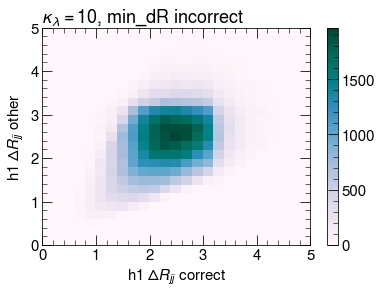

In [64]:
plt.hist2d(dR1_correct,dR1_other,25,[[0,5],[0,5]],cmap='PuBuGn',
           weights=w[mask])

plt.title('$\kappa_\lambda = 10$, min_dR incorrect',loc='left')
plt.xlabel('h1 $\Delta R_{jj}$ correct')
plt.ylabel('h1 $\Delta R_{jj}$ other')
plt.colorbar()

plt.figure()
plt.hist2d(dR2_correct,dR2_other,25,[[0,5],[0,5]],cmap='GnBu',
           weights=w[mask])

plt.title('$\kappa_\lambda = 10$, min_dR incorrect',loc='left')
plt.xlabel('h2 $\Delta R_{jj}$ correct')
plt.ylabel('h2 $\Delta R_{jj}$ other')
plt.colorbar()

plt.show()

Wow this looks wierd (esp for the subleading HC pairs). But the fact that these distributions are approximately symmetric is actually a pretty powerful handle here.


Let's try to look at some variables which probe the symmetry between these 2 pairs!!


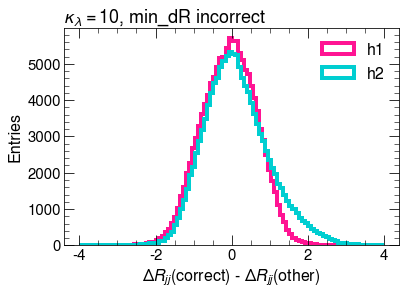

In [65]:
plt.hist(dR1_correct-dR1_other,100,(-4,4),color='deeppink',
         histtype='step',lw=4,label='h1', weights=w[mask])
plt.hist(dR2_correct-dR2_other,100,(-4,4),color='darkturquoise',
         histtype='step',lw=4,label='h2', weights=w[mask])

plt.xlabel('$\Delta R_{jj}$(correct) - $\Delta R_{jj}$(other)',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('$\kappa_\lambda = 10$, min_dR incorrect',loc='left')
plt.legend(fontsize=16)

plt.show()

**Cool** - this seems like a *reasonably* powerful variables to use rn!

- h2 is more *asymmetric* and has more correct pairs with a larger opening angle
- But capitalizing on the h1 distribution is *consistent* with what we're doing with the min_dR pairing alg.
- Also, since we won't know which pair is correct and which is incorrect at test time, it might be nice to just use the h1 variable and take the *average* of the masses??

**Idea:** We could try weighting the two events by the h2 symmetry somehow??

But first, let's just check how symmetric these h1 events actually are!!


In [66]:
plt.hist(dR1_correct-dR1_other,100,(-4,4),color='deeppink',
         histtype='step',lw=4,weights=w[mask],label='actual')

n,e = np.histogram(np.abs(dR1_correct-dR1_other),50,(0,4),weights=w[mask])

xx = 0.5*(e[1:]+e[:-1])

plt.scatter(xx,0.5*n,color='darkorchid',label='abs + sym')
plt.scatter(-xx,0.5*n,color='darkorchid')

plt.xlabel('h1 $\Delta R_{jj}$(correct) - $\Delta R_{jj}$(other)',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.title('$\kappa_\lambda = 10$, min_dR incorrect',loc='left')
plt.legend(fontsize=16)

plt.show()

Ok, so h1 has the "other" pairing with a slightly larger opening angle bewtween the daughters.

Just interesting since this is the opposite trend that we were seeing with h2.

**First idea to isolate these events:***
- Put a cutoff at 1, then let's check the massplane distributions, and maybe also the $\Delta \eta_{hh}$ plots, since these are the 2 places that the pairing has an impact on our analysis.

In [67]:
m = np.abs(dR1_correct-dR1_other) < 1

In [68]:
x1, y1 = 124, 117

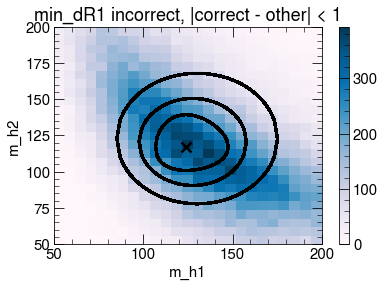

In [69]:
plt.hist2d(m1_other[m],m2_other[m],25,[[50,200],[50,200]],
           cmap='PuBu',weights=w[mask][m])

plt.colorbar()

for f in [draw_SR,draw_VR,draw_CR]:
    xx,yy = f(x1,y1)
    plt.plot(xx,yy,'k-')
plt.scatter([x1],[y1],100,color='k',marker='x')
    
plt.xlabel('m_h1')
plt.ylabel('m_h2')

plt.title('min_dR1 incorrect, |correct - other| < 1')

plt.show()

Ok, this *isn't perfect*, but also isn't bad.

I mean, VR contamination might be more of an issue than it was before, but the goal here was just to help the signal efficiency lol.


What if instead I plotted the means? (Idk if this is the most fair comparison tho lol since the correct pair is just always going to be @ 125 for truth pairs.)

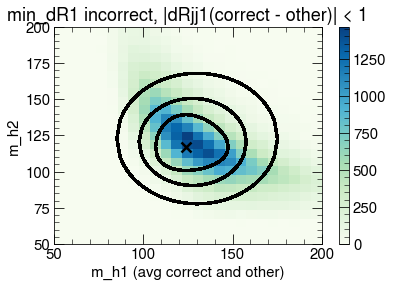

In [70]:
plt.hist2d(0.5*(m1_other[m]+125),0.5*(m2_other[m]+125),
           25,[[50,200],[50,200]],
           cmap='GnBu',weights=w[mask][m])

plt.colorbar()

for f in [draw_SR,draw_VR,draw_CR]:
    xx,yy = f(x1,y1)
    plt.plot(xx,yy,'k-')
plt.scatter([x1],[y1],100,color='k',marker='x')
    
plt.xlabel('m_h1 (avg correct and other)')
plt.ylabel('m_h2')

plt.title('min_dR1 incorrect, |dRjj1(correct - other)| < 1')

plt.show()

Yep, cleans it up a little bit!! Def worth *reinvestigating* this for the reco level analysis.

**How about the $\Delta \eta_{hh}$ variable?**

In [71]:
eta1s = [f'pair{pi}_h1_eta' for pi in range(3)]
eta2s = [f'pair{pi}_h2_eta' for pi in range(3)]

eta1_chosen = df[eta1s].values[np.arange(len(df)),df.chosen_min_dR][mask]
eta2_chosen = df[eta2s].values[np.arange(len(df)),df.chosen_min_dR][mask]

eta1_correct = df[eta1s].values[np.arange(len(df)),df.correctPair][mask]
eta2_correct = df[eta2s].values[np.arange(len(df)),df.correctPair][mask]

eta1_other = df.loc[mask,eta1s].values[other]
eta2_other = df.loc[mask,eta2s].values[other]

In [72]:
deta_chosen = np.abs(eta1_chosen - eta2_chosen)

deta_correct = np.abs(eta1_correct - eta2_correct)
deta_other = np.abs(eta1_other - eta2_other)

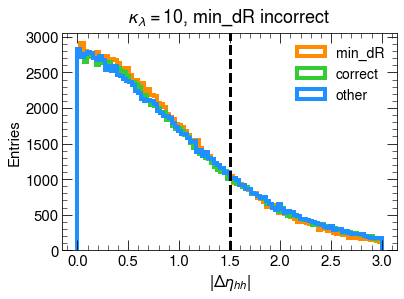

In [73]:
nm,e,_ = plt.hist(deta_chosen,100,(0,3),color='darkorange',
         histtype='step',lw=4,label='min_dR',
         weights=w[mask])

nc,e,_ = plt.hist(deta_correct,100,(0,3),color='limegreen',
                  histtype='step',lw=4,label='correct', weights=w[mask])
no,_,_ = plt.hist(deta_other,100,(0,3),color='dodgerblue',
                  histtype='step',lw=4,label='other', weights=w[mask])

plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=16)
plt.ylabel('Entries')
plt.legend()
plt.title('$\kappa_\lambda = 10$, min_dR incorrect',va='bottom')

ylim = plt.ylim()
plt.plot([1.5]*2,ylim,'k--')
plt.ylim(ylim)

plt.show()


# Plot the ratio?
plt.figure()
xx = 0.5 * (e[1:] + e[:-1])

plt.plot(xx,nm/nc,'darkorange',label='min_dR')
plt.plot(xx,no/nc,'dodgerblue',label='other')
plt.plot(xx,np.ones_like(xx),color='limegreen',ls='--')

plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=16)
plt.ylabel('1 / correct')
plt.title('$\kappa_\lambda = 10$, min_dR incorrect',va='bottom')
plt.legend()
plt.show()

Yey!!! This is *awesome* that this variable looks so similar between correct and other, i.e, I should be chill just looking at the average of these 2 pairs for the rest of the analysis.

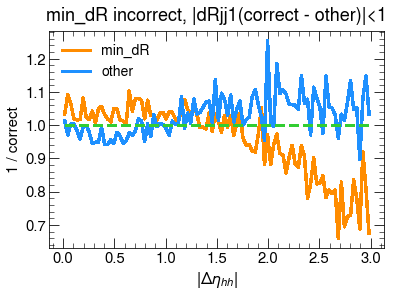

In [74]:
nm,e,_ = plt.hist(deta_chosen[m],100,(0,3),color='darkorange',
         histtype='step',lw=4,label='min_dR',
         weights=w[mask][m])

nc,e,_ = plt.hist(deta_correct[m],100,(0,3),color='limegreen',
                  histtype='step',lw=4,label='correct', weights=w[mask][m])
no,_,_ = plt.hist(deta_other[m],100,(0,3),color='dodgerblue',
                  histtype='step',lw=4,label='other', weights=w[mask][m])

plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=16)
plt.ylabel('Entries')
plt.legend()
plt.title('min_dR incorrect, |dRjj1(correct - other)|<1',va='bottom')

ylim = plt.ylim()
plt.plot([1.5]*2,ylim,'k--')
plt.ylim(ylim)

plt.show()


# Plot the ratio?
plt.figure()
xx = 0.5 * (e[1:] + e[:-1])

plt.plot(xx,nm/nc,'darkorange',label='min_dR')
plt.plot(xx,no/nc,'dodgerblue',label='other')
plt.plot(xx,np.ones_like(xx),color='limegreen',ls='--')

plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=16)
plt.ylabel('1 / correct')
plt.title('min_dR incorrect, |dRjj1(correct - other)|<1',va='bottom')
plt.legend()
plt.show()

Helps us isolate a little more the effect we were trying to probe, and I think makes the difference b/w min_dR and other *bigger*.

**Adding a layer of realism**

Ok, so this line of reasoning seems *promising*, but now I think that we're at a place where we want to add a level of realism. I.e, before the analysis was done with the "correct" info, so now I want to find a *reco* level way to explore the same topology.

**Plan:** Let's look at the difference of the opening angles b/w two of the options for the leading HC.

In [75]:
df[f'comb0_dR1diff'] = np.abs(df[f'pair1_dR_h1'] - df[f'pair2_dR_h1'])
df[f'comb1_dR1diff'] = np.abs(df[f'pair0_dR_h1'] - df[f'pair2_dR_h1'])
df[f'comb2_dR1diff'] = np.abs(df[f'pair0_dR_h1'] - df[f'pair1_dR_h1'])

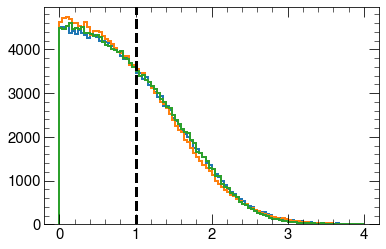

In [76]:
plt.hist(df[f'comb0_dR1diff'],100,(0,4),color='C0',histtype='step',lw=2,weights=w)
plt.hist(df[f'comb1_dR1diff'],100,(0,4),color='C1',histtype='step',lw=2,weights=w)
plt.hist(df[f'comb2_dR1diff'],100,(0,4),color='C2',histtype='step',lw=2,weights=w)

ylim = plt.ylim()
plt.plot([1]*2,ylim,'k--')
plt.ylim(ylim)
plt.show()

Ugh - at first blush, this doesn't seem like a lot of discrimination :/

In [77]:
comb_i = np.argmin(df[[f'comb{i}_dR1diff' for i in range(3)]].values,axis=1)

In [78]:
comb_i

array([0, 0, 2, ..., 0, 2, 2])

In [79]:
min_diff = df[[f'comb{i}_dR1diff' for i in range(3)]].values[np.arange(len(df)),comb_i]

In [80]:
plt.hist(min_diff,100,(0,4),color='deeppink',histtype='step',lw=4,weights=w)
plt.xlabel('min dR1 diff')

Text(0.5, 0, 'min dR1 diff')

Yes!! And - this cut at 1 *might* even be too efficient to still allow some space for the min_dR category.

**Plan:** Break this curve down by the values where dR1 *is* and *is not* included in this pairing.

Text(0.5, 1.0, '$\\kappa_\\lambda = 10$')

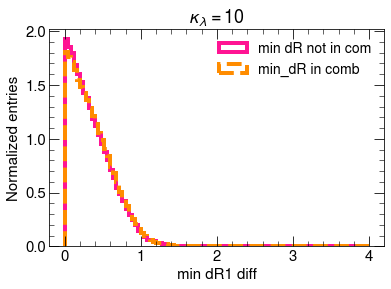

In [81]:
plt.hist(min_diff[comb_i!=df.chosen_min_dR],
         100,(0,4),color='deeppink',histtype='step',lw=4,
         density=True,label='min dR not in com',
         weights=w[comb_i!=df.chosen_min_dR])
plt.hist(min_diff[comb_i==df.chosen_min_dR],
         100,(0,4),color='darkorange',histtype='step',lw=4,
         density=True,ls='--',label='min_dR in comb',
         weights=w[comb_i==df.chosen_min_dR])
plt.xlabel('min dR1 diff')
plt.ylabel('Normalized entries')
plt.legend()
plt.title('$\kappa_\lambda = 10$')

Ugh. There is literally *no* discrimination power with this variable.

Maybe I need to use $H_T$ or just directly $m_{hh}$ to split these 2 categories??

In [82]:
mhh

array([303.18597336, 276.07439946, 429.63441624, ..., 252.26564823,
       380.72893233, 418.56536987])

In [83]:
num = np.histogram2d(mhh[comb_i!=df.chosen_min_dR],min_diff[comb_i!=df.chosen_min_dR],
                     25,[[250,750],[0,1.5]],weights=w[comb_i!=df.chosen_min_dR])[0]
den = np.histogram2d(mhh,min_diff,25,[[250,750],[0,1.5]],weights=w)[0]

In [84]:
plt.imshow((num/den).T,origin='lower')

plt.xlabel('m_hh')
plt.ylabel('min_dR diff')

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'min_dR diff')

In [85]:
e = np.linspace(250,750,26)

Text(0.5, 0, 'm_hh [GeV]')

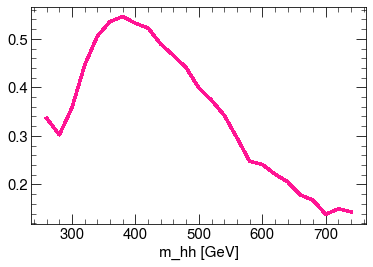

In [86]:
num,e = np.histogram(mhh[comb_i!=df.chosen_min_dR],25,[250,750],
                     weights=w[comb_i!=df.chosen_min_dR])
den = np.histogram(mhh,25,[250,750],weights=w)[0]

x = 0.5*(e[1:]+e[:-1])
y = num / den

plt.plot(x,y,color='deeppink')
plt.xlabel('m_hh [GeV]')

Hmmmm - I'm really not sure what the above plot is telling us...

Text(0, 0.5, 'min_dR accuracy')

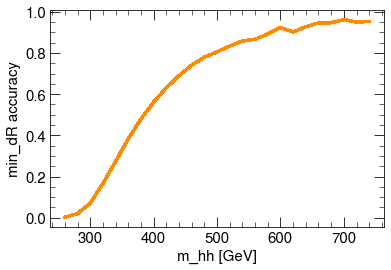

In [87]:
num = np.histogram(mhh[df.correctPair==df.chosen_min_dR],
                     25,[250,750],weights=w[df.correctPair==df.chosen_min_dR])[0]
y = num / den
plt.plot(x,y,color='darkorange')

plt.xlabel('m_hh [GeV]')
plt.ylabel('min_dR accuracy')

At 400 GeV, roughly 60% accurate, so ok, this seems like a reasonable place to cut at.

But ok, in summary, turns out trying to get a cut that probed the symmetric variables didn't work out so well, but maybe just *cutting* at 400 or 300 GeV should be sufficient.

**Next:** Let's check how the signal efficiency is impacted by this cut.

Where by *signal efficiency* I'm going to be considering the SR centered at (124, 117) GeV, and then also apply the 4b-jets and deta cuts.

I'm skipping trigger rn even though it's important j b/c we're 90% efficient after the jet selection cuts, and I'm not really trying to be as formal as possible rn.

In [94]:
# for k in tree.keys():
#     if 'resolved' in k.decode():
#         print(k)

In [89]:
jcols = [f'resolvedJets_{v}' for v in ['pt','eta','is_DL1r_FixedCutBEff_77']]

In [90]:
jarr = tree.arrays(jcols)

In [91]:
jmask = (jarr[b'resolvedJets_pt'] > 40)  & (abs(jarr[b'resolvedJets_eta']) < 2.5)

df['njets'] = jmask.sum()

bmask = jmask & jarr[b'resolvedJets_is_DL1r_FixedCutBEff_77']
df['ntag'] = bmask.sum()


In [171]:
jmask = (jarr[b'resolvedJets_pt'] > 30)  & (abs(jarr[b'resolvedJets_eta']) < 2.5)

df['njets_low_pt'] = jmask.sum()

bmask = jmask & jarr[b'resolvedJets_is_DL1r_FixedCutBEff_77']
df['ntag_low_pt'] = bmask.sum()



Wow - pre analysis cuts, this spectrum is *quite soft*.

In [92]:
plt.hist(df['njets'],11,(-0.5,10.5),weights=w)
plt.xlabel('njets')
plt.show()

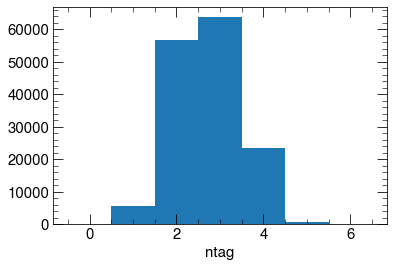

In [93]:
plt.hist(df.loc[df.njets>=4,'ntag'],7,(-0.5,6.5))
plt.xlabel('ntag')
plt.show()

Ok, right, I *knew* these were quite stringent cuts to apply to the analysis, maybe I should redo some of the earlier analysis now that I know that this is so important?

**Step 1:** $\kappa_\lambda$ accuracy

In [123]:
mi = df.ntag>=4

np.sum(w[mi & (df.correctPair == df.chosen_min_dR)]) / np.sum(w[mi])

0.42762083

Text(0.5, 1.0, '$\\kappa_\\lambda = 10$')

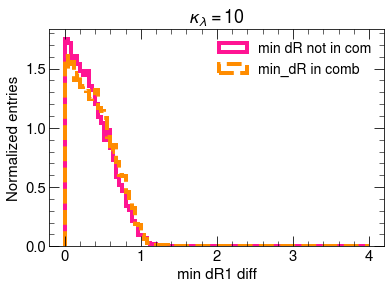

In [99]:
plt.hist(min_diff[mi & (comb_i!=df.chosen_min_dR)],
         100,(0,4),color='deeppink',histtype='step',lw=4,
         density=True,label='min dR not in com',
         weights=w[mi & (comb_i!=df.chosen_min_dR)])
plt.hist(min_diff[mi & (comb_i==df.chosen_min_dR)],
         100,(0,4),color='darkorange',histtype='step',lw=4,
         density=True,ls='--',label='min_dR in comb',
         weights=w[mi & (comb_i==df.chosen_min_dR)])
plt.xlabel('min dR1 diff')
plt.ylabel('Normalized entries')
plt.legend()
plt.title('$\kappa_\lambda = 10$, ntag == 4b')

Ok, when we *zone in* on 4b, there is slightly more separation b/w these two.

Text(0.5, 0.98, '$\\kappa_\\lambda = 10$, ntag == 4b')

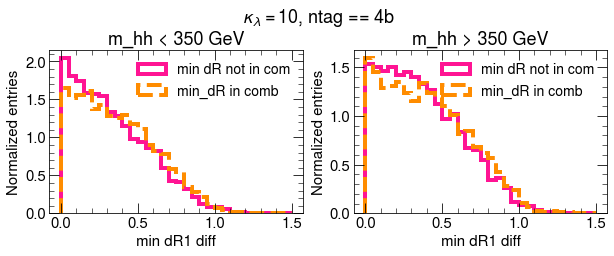

In [104]:
mhh_cutoff = 350

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3))

ax1.hist(min_diff[mi & (comb_i!=df.chosen_min_dR) & (mhh < mhh_cutoff)],
         30,(0,1.5),color='deeppink',histtype='step',lw=4,
         density=True,label='min dR not in com',
         weights=w[mi & (comb_i!=df.chosen_min_dR) & (mhh < mhh_cutoff)])
ax1.hist(min_diff[mi & (comb_i==df.chosen_min_dR) & (mhh < mhh_cutoff)],
         30,(0,1.5),color='darkorange',histtype='step',lw=4,
         density=True,ls='--',label='min_dR in comb',
         weights=w[mi & (comb_i==df.chosen_min_dR) & (mhh < mhh_cutoff)])

ax1.set_xlabel('min dR1 diff')
ax1.set_ylabel('Normalized entries')
ax1.set_title(f'm_hh < {mhh_cutoff} GeV')
ax1.legend()

ax2.hist(min_diff[mi & (comb_i!=df.chosen_min_dR) & (mhh > mhh_cutoff)],
         30,(0,1.5),color='deeppink',histtype='step',lw=4,
         density=True,label='min dR not in com',
         weights=w[mi & (comb_i!=df.chosen_min_dR) & (mhh > mhh_cutoff)])
ax2.hist(min_diff[mi & (comb_i==df.chosen_min_dR) & (mhh > mhh_cutoff)],
         30,(0,1.5),color='darkorange',histtype='step',lw=4,
         density=True,ls='--',label='min_dR in comb',
         weights=w[mi & (comb_i==df.chosen_min_dR) & (mhh > mhh_cutoff)])

ax2.set_xlabel('min dR1 diff')
ax2.set_ylabel('Normalized entries')
ax2.set_title(f'm_hh > {mhh_cutoff} GeV')
ax2.legend()

fig.suptitle('$\kappa_\lambda = 10$, ntag == 4b',va='bottom')

Hmmmm, still not a lot of discrimination.

**Plan:** Do a basic implementation of 2 analysis cutflows
1. For min_dR
2. For the avg of this minimizing combination

Then make plots of the signal yield in the SR for *each* of these 2 options.

In [108]:
len(m1_chosen),len(df)

(220499, 308146)

In [111]:
m1s

array([125.000015, 125.00001 , 125.00009 , ..., 125.00001 , 124.99986 ,
       125.00001 ], dtype=float32)

In [120]:
df['deta_hh_min_dR'] = np.abs(df[eta1s].values[np.arange(len(df)),df.chosen_min_dR] \
                              - df[eta2s].values[np.arange(len(df)),df.chosen_min_dR])

df['m_h1_min_dR'] = df[m_h1s].values[np.arange(len(df)),df.chosen_min_dR]
df['m_h2_min_dR'] = df[m_h2s].values[np.arange(len(df)),df.chosen_min_dR]

#df['kr'] = 3
df['Xhh_min_dR'] = getXhh(*df[['m_h1_min_dR','m_h2_min_dR']].values.T,x1,y1)


Text(0.5, 1.0, '$\\kappa_\\lambda = 10$, ntag == 4b')

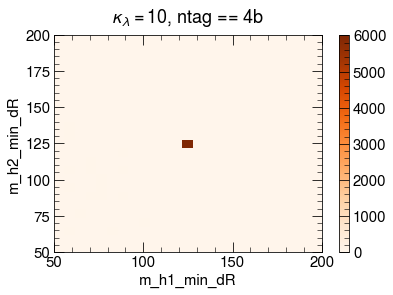

In [133]:
plt.hist2d(*df.loc[mi,['m_h1_min_dR','m_h2_min_dR']].values.T,
           25,[[50,200],[50,200]], cmap='Oranges',weights=w[mi])
plt.colorbar()
plt.xlabel('m_h1_min_dR')
plt.ylabel('m_h2_min_dR')
plt.title('$\kappa_\lambda = 10$, ntag == 4b',va='bottom')

Conclusion, unless I *mask out* the min_dR correct events, this is the only feature that's visible on the plot.

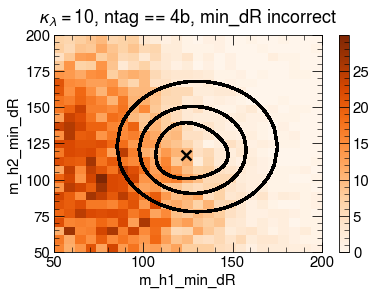

In [135]:
plt.hist2d(*df.loc[mi& (df.correctPair != df.chosen_min_dR),['m_h1_min_dR','m_h2_min_dR']].values.T,
           25,[[50,200],[50,200]], cmap='Oranges',
           weights=w[mi& (df.correctPair != df.chosen_min_dR)])
plt.colorbar()
plt.xlabel('m_h1_min_dR')
plt.ylabel('m_h2_min_dR')
plt.title('$\kappa_\lambda = 10$, ntag == 4b, min_dR incorrect',va='bottom')


for f in [draw_SR,draw_VR,draw_CR]:
    xx,yy = f(x1,y1)
    plt.plot(xx,yy,'k-')
plt.scatter([x1],[y1],100,color='k',marker='x')
plt.show()

### Minimize the difference

In [136]:
for ci in ['deta_hh','m_h1','m_h2']:
    df[f'{ci}_avg'] = 0

In [140]:
for c in df.columns:
    if 'h1' in c:
        print(c)

pair0_h1_pt
pair0_h1_eta
pair0_h1_phi
pair0_h1_m
pair1_h1_pt
pair1_h1_eta
pair1_h1_phi
pair1_h1_m
pair2_h1_pt
pair2_h1_eta
pair2_h1_phi
pair2_h1_m
pair0_deta_h1
pair0_dphi_h1
pair0_dR_h1
pair1_deta_h1
pair1_dphi_h1
pair1_dR_h1
pair2_deta_h1
pair2_dphi_h1
pair2_dR_h1
m_h1_min_dR
m_h1_avg


In [141]:
for i, p1,p2 in zip(range(3),[1,0,0],[2,2,1]):

    deta_p1 = np.abs(df.loc[comb_i==i,f'pair{p1}_h1_eta']
                     - df.loc[comb_i==i,f'pair{p1}_h2_eta'])
    deta_p2 = np.abs(df.loc[comb_i==i,f'pair{p2}_h1_eta']
                     - df.loc[comb_i==i,f'pair{p2}_h2_eta'])
    
    df.loc[comb_i==i,'deta_hh_avg'] = 0.5 * (deta_p1 + deta_p2)

    df.loc[comb_i==i,'m_h1_avg'] = 0.5 * ( df.loc[comb_i==i,f'pair{p1}_h1_m']
                                         + df.loc[comb_i==i,f'pair{p2}_h1_m'] )
    df.loc[comb_i==i,'m_h2_avg'] = 0.5 * ( df.loc[comb_i==i,f'pair{p1}_h2_m']
                                         + df.loc[comb_i==i,f'pair{p2}_h2_m'] )

In [142]:
df['Xhh_avg'] = getXhh(*df[['m_h1_avg','m_h2_avg']].values.T,x1,y1)

In [144]:
plt.hist(df['Xhh_avg'],100,(0,10),weights=w)

(array([ 203.96313477,  586.05566406,  953.39538574, 1360.79431152,
        1728.96337891, 2097.11743164, 2481.38061523, 2740.51245117,
        2912.47216797, 3241.5168457 , 3314.70214844, 3511.22509766,
        3595.01293945, 3824.96557617, 3799.56494141, 3837.91455078,
        3807.50878906, 3899.94775391, 3775.79443359, 3895.3984375 ,
        3836.79370117, 3848.83007812, 3688.67993164, 3652.06738281,
        3526.59960938, 3507.26782227, 3494.74511719, 3341.73510742,
        3251.08642578, 3250.74926758, 3111.52978516, 3003.5065918 ,
        3013.08520508, 2955.45629883, 2872.92651367, 2753.27758789,
        2747.84790039, 2612.82788086, 2611.21923828, 2478.44995117,
        2432.14453125, 2340.10595703, 2311.67382812, 2232.76147461,
        2130.89599609, 2178.83544922, 2067.06689453, 2037.66760254,
        1915.31323242, 2030.8795166 , 1889.09814453, 1804.65527344,
        1733.98925781, 1632.79443359, 1610.52587891, 1528.76806641,
        1462.88513184, 1401.65148926, 1338.83166

Text(0.5, 1.0, 'kl = 10, 4b, mhh_cutoff < 350 GeV')

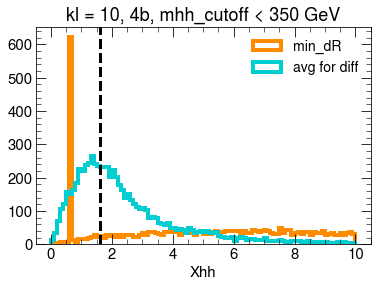

In [160]:
plt.hist(df.loc[(df.ntag >=4) & (mhh<350),'Xhh_min_dR'],100,(0,10),
         weights=w[(df.ntag >=4) & (mhh<350)],
         color='darkorange',histtype='step',lw=4,
         label='min_dR')


plt.hist(df.loc[(df.ntag >=4) & (mhh<350),'Xhh_avg'],100,(0,10),
         weights=w[(df.ntag >=4) & (mhh<350)],
         color='darkturquoise',histtype='step',lw=4,label='avg for diff')

plt.xlabel('Xhh')
plt.legend()
ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k--')
plt.ylim(ylim)
plt.title('kl = 10, 4b, mhh_cutoff < 350 GeV')

Ooooh - cool!! Let's make a 2d plot!!

In [158]:
plt.hist2d(df.loc[(df.ntag >=4) & (mhh<350),'Xhh_min_dR'],
           df.loc[(df.ntag >=4) & (mhh<350),'Xhh_avg'], 25, [(0,5),(0,5)], 
           cmap='twilight',weights=w[(df.ntag >=4) & (mhh<350)])

plt.colorbar()
plt.xlabel('Xhh min_dR')
plt.ylabel('Xhh avg dR1 diff')

plt.plot([1.6]*2,[0,5],'k--')
plt.plot([0,5],[1.6]*2,'k--')
plt.xlim([0,5])
plt.ylim([0,5])

plt.title('kl = 10, 4b, mhh_cutoff < 350 GeV')

Text(0.5, 1.0, 'kl = 10, 4b, mhh_cutoff < 350 GeV')

In [159]:
# Have the den be 4b mhh < 350 events
den = np.sum(w[(df.ntag >=4) & (mhh<350)])

num = np.sum(w[(df.ntag >=4) & (mhh<350) & (df.Xhh_min_dR < 1.6) & (df.Xhh_avg < 1.6)])
print('both < 1.6', num / den)

num = np.sum(w[(df.ntag >=4) & (mhh<350) & (df.Xhh_min_dR < 1.6) & (df.Xhh_avg > 1.6)])
print('min_dR1 < 1.6, avg > 1.6', num / den)

num = np.sum(w[(df.ntag >=4) & (mhh<350) & (df.Xhh_min_dR > 1.6) & (df.Xhh_avg < 1.6)])
print('min_dR1 > 1.6, avg < 1.6', num / den)

num = np.sum(w[(df.ntag >=4) & (mhh<350) & (df.Xhh_min_dR > 1.6) & (df.Xhh_avg > 1.6)])
print('both > 1.6', num / den)

both < 1.6 0.051597435
min_dR1 < 1.6, avg > 1.6 0.06261029
min_dR1 > 1.6, avg < 1.6 0.32693714
both > 1.6 0.5588552


For completeness, $m_{hh} > 350$ GeV

Text(0.5, 1.0, 'kl = 10, 4b, mhh_cutoff > 350 GeV')

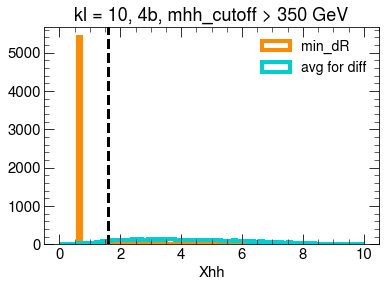

In [162]:
plt.hist(df.loc[(df.ntag >=4) & (mhh>350),'Xhh_min_dR'],100,(0,10),
         weights=w[(df.ntag >=4) & (mhh>350)],
         color='darkorange',histtype='step',lw=4,
         label='min_dR')


plt.hist(df.loc[(df.ntag >=4) & (mhh>350),'Xhh_avg'],100,(0,10),
         weights=w[(df.ntag >=4) & (mhh>350)],
         color='darkturquoise',histtype='step',lw=4,label='avg for diff')

plt.xlabel('Xhh')
plt.legend()
ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k--')
plt.ylim(ylim)
plt.title('kl = 10, 4b, mhh_cutoff > 350 GeV')

In [163]:
# Have the den be 4b mhh < 350 events
den = np.sum(w[(df.ntag >=4) & (mhh>350)])

num = np.sum(w[(df.ntag >=4) & (mhh>350) & (df.Xhh_min_dR < 1.6) & (df.Xhh_avg < 1.6)])
print('both < 1.6', num / den)

num = np.sum(w[(df.ntag >=4) & (mhh>350) & (df.Xhh_min_dR < 1.6) & (df.Xhh_avg > 1.6)])
print('min_dR1 < 1.6, avg > 1.6', num / den)

num = np.sum(w[(df.ntag >=4) & (mhh>350) & (df.Xhh_min_dR > 1.6) & (df.Xhh_avg < 1.6)])
print('min_dR1 > 1.6, avg < 1.6', num / den)

num = np.sum(w[(df.ntag >=4) & (mhh>350) & (df.Xhh_min_dR > 1.6) & (df.Xhh_avg > 1.6)])
print('both > 1.6', num / den)

both < 1.6 0.05341016
min_dR1 < 1.6, avg > 1.6 0.7282929
min_dR1 > 1.6, avg < 1.6 0.020682702
both > 1.6 0.19761415


**Finally** do a quick check including the $\Delta \eta_{hh}$ cut as well.

Text(0.5, 1.0, 'kl = 10, 4b deta cut')

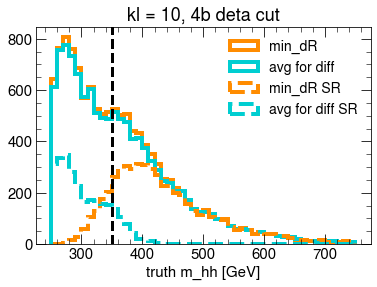

In [170]:
plt.hist(mhh[(df.ntag >=4) & (df.deta_hh_min_dR < 1.5)],50,(250,750),
         weights=w[(df.ntag >=4) & (df.deta_hh_min_dR < 1.5)],
         color='darkorange',histtype='step',lw=4,
         label='min_dR')

plt.hist(mhh[(df.ntag >=4) & (df.deta_hh_avg < 1.5)],50,(250,750),
         weights=w[(df.ntag >=4) & (df.deta_hh_avg < 1.5)],
         color='darkturquoise',histtype='step',lw=4,label='avg for diff')


plt.hist(mhh[(df.ntag >=4) & (df.deta_hh_min_dR < 1.5) & (df.Xhh_min_dR<1.6)],50,(250,750),
         weights=w[(df.ntag >=4) & (df.deta_hh_min_dR < 1.5) & (df.Xhh_min_dR<1.6)],
         color='darkorange',histtype='step',lw=4,ls='--',
         label='min_dR SR')

plt.hist(mhh[(df.ntag >=4) & (df.deta_hh_avg < 1.5) & (df.Xhh_avg<1.6)],50,(250,750),
         weights=w[(df.ntag >=4) & (df.deta_hh_avg < 1.5) & (df.Xhh_avg<1.6)],
         color='darkturquoise',histtype='step',lw=4,ls='--',label='avg for diff SR')

plt.xlabel('truth m_hh [GeV]')
plt.legend()
ylim = plt.ylim()
plt.plot([350]*2,ylim,'k--')
plt.ylim(ylim)
plt.title('kl = 10, 4b+deta cut')

Text(0.5, 1.0, 'kl = 10, 4b (pT > 30 GeV) +deta cut')

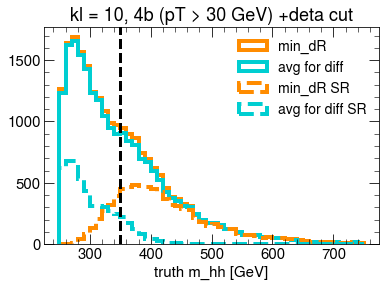

In [172]:
plt.hist(mhh[(df.ntag_low_pt >=4) & (df.deta_hh_min_dR < 1.5)],50,(250,750),
         weights=w[(df.ntag_low_pt >=4) & (df.deta_hh_min_dR < 1.5)],
         color='darkorange',histtype='step',lw=4,
         label='min_dR')

plt.hist(mhh[(df.ntag_low_pt >=4) & (df.deta_hh_avg < 1.5)],50,(250,750),
         weights=w[(df.ntag_low_pt >=4) & (df.deta_hh_avg < 1.5)],
         color='darkturquoise',histtype='step',lw=4,label='avg for diff')


plt.hist(mhh[(df.ntag_low_pt >=4) & (df.deta_hh_min_dR < 1.5) & (df.Xhh_min_dR<1.6)],50,(250,750),
         weights=w[(df.ntag_low_pt >=4) & (df.deta_hh_min_dR < 1.5) & (df.Xhh_min_dR<1.6)],
         color='darkorange',histtype='step',lw=4,ls='--',
         label='min_dR SR')

plt.hist(mhh[(df.ntag_low_pt >=4) & (df.deta_hh_avg < 1.5) & (df.Xhh_avg<1.6)],50,(250,750),
         weights=w[(df.ntag_low_pt >=4) & (df.deta_hh_avg < 1.5) & (df.Xhh_avg<1.6)],
         color='darkturquoise',histtype='step',lw=4,ls='--',label='avg for diff SR')

plt.xlabel('truth m_hh [GeV]')
plt.legend()
ylim = plt.ylim()
plt.plot([350]*2,ylim,'k--')
plt.ylim(ylim)
plt.title('kl = 10, 4b (pT > 30 GeV) +deta cut')

Text(0.5, 1.0, 'kl = 10, 4b (low pT) +deta cut')

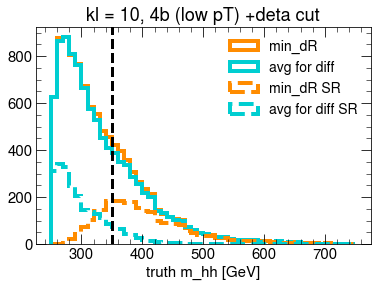

In [175]:
plt.hist(mhh[(df.ntag <4) & (df.ntag_low_pt >=4) & (df.deta_hh_min_dR < 1.5)],50,(250,750),
         weights=w[(df.ntag <4) & (df.ntag_low_pt >=4) & (df.deta_hh_min_dR < 1.5)],
         color='darkorange',histtype='step',lw=4,
         label='min_dR')

plt.hist(mhh[(df.ntag <4) & (df.ntag_low_pt >=4) & (df.deta_hh_avg < 1.5)],50,(250,750),
         weights=w[(df.ntag <4) & (df.ntag_low_pt >=4) & (df.deta_hh_avg < 1.5)],
         color='darkturquoise',histtype='step',lw=4,label='avg for diff')


plt.hist(mhh[(df.ntag <4) & (df.ntag_low_pt >=4) & (df.deta_hh_min_dR < 1.5) & (df.Xhh_min_dR<1.6)],50,(250,750),
         weights=w[(df.ntag <4) & (df.ntag_low_pt >=4) & (df.deta_hh_min_dR < 1.5) & (df.Xhh_min_dR<1.6)],
         color='darkorange',histtype='step',lw=4,ls='--',
         label='min_dR SR')

plt.hist(mhh[(df.ntag <4) & (df.ntag_low_pt >=4) & (df.deta_hh_avg < 1.5) & (df.Xhh_avg<1.6)],50,(250,750),
         weights=w[(df.ntag <4) & (df.ntag_low_pt >=4) & (df.deta_hh_avg < 1.5) & (df.Xhh_avg<1.6)],
         color='darkturquoise',histtype='step',lw=4,ls='--',label='avg for diff SR')

plt.xlabel('truth m_hh [GeV]')
plt.legend()
ylim = plt.ylim()
plt.plot([350]*2,ylim,'k--')
plt.ylim(ylim)
plt.title('kl = 10, 4b (low pT) +deta cut')